# 데이터 호출

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import csv,os
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

from tensorflow.python.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,Dense,Activation,Dropout,MaxPooling2D
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam

In [3]:
def readCsv(path):
    with open (path,'r') as f:
        reader = csv.DictReader(f)
        rows=list(reader)
    #imgs is a numpy array with all the images
    #tgs is a numpy array with the tags of the images

    height=26 # 26 X 34
    width=34
    
    imgs= np.empty((len(list(rows)),height,width,1),dtype=np.uint8)    # numpy.empty(shape, dtype=float, order='C', *, like=None)
    tgs=np.empty((len(list(rows)),1))
    imgs_flip= np.empty((len(list(rows)),height,width,1),dtype=np.uint8) # 좌우반전

    for row,i in zip(rows,range(len(rows))):
        #convert the list back to the image format

        img= row['image']
        img=img.strip('[').strip(']').split(',')

        # rows= OrderedDict([('state', 'open'),
        #       ('image',
        #        '[88, 91, 95, 99, 102, 106, 109, 110, 113, 114, 118, 122, 123, 125, 126, 124, 125, 123, 124, 123, 120, 114, 117, 112, 108, 105, 100......)

        im=np.array(img,dtype=np.uint8) # uint8	부호 없는(unsigned) 8비트, 1바이트 정수	0 ~ 255
        im=im.reshape((26,34))
        im=np.expand_dims(im,axis=2) # 3차원 추가(1= 흑백)
        imgs[i]=im
        imgs_flip[i]=np.fliplr(im)

        #the tag for open is 1 and for close is 0

        tag= row['state']
        if tag == 'open':
            tgs[i]=1
        else:
            tgs[i]=0
    # 좌우 반전
    imgs_concat=np.concatenate((imgs,imgs_flip))
    tgs_concat=np.concatenate((tgs,tgs))

    #return images and their respective tags
    return imgs_concat , tgs_concat

In [4]:
X,y=readCsv('/content/drive/MyDrive/Colab Notebooks/업로드용 자료/dataset.csv')

# 추가 데이터 - 동양인 눈 크로핑 데이터

In [5]:
crop_dir='/content/drive/MyDrive/Colab Notebooks/업로드용 자료/크로핑'

file_names=os.listdir(crop_dir)

In [6]:
height=26
width=34
imgs= np.empty((len(list(file_names)),height,width,1),dtype=np.uint8)
y_ex=[]

for file_name,i in zip(file_names,range(len(file_names))):
    crop=os.path.join(crop_dir,file_name)
    im=load_img(crop,target_size=(height,width),grayscale=True)
    im=np.array(im,dtype=np.uint8)
    im=np.expand_dims(im,axis=2)
    imgs[i]=im
    y_ex.append(1)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [7]:
k=y_ex.copy()

In [8]:
k=np.expand_dims(k,axis=1)

In [9]:
y_ex=k

In [10]:
imgs.shape , y_ex.shape

((13620, 26, 34, 1), (13620, 1))

In [11]:
X=np.concatenate((X,imgs))
y=np.concatenate((y,y_ex))

In [12]:
X_train,X_val,y_train,y_val=train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.shape, y_train.shape,X_val.shape,y_val.shape

((15494, 26, 34, 1), (15494, 1), (3874, 26, 34, 1), (3874, 1))

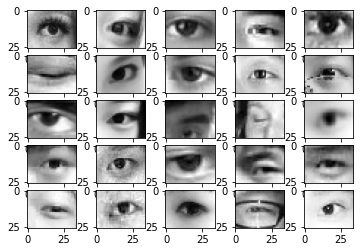

In [14]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i].reshape((26, 34)), cmap='gray') # (26,34,1)이라서 (26,34)로 변경해준다

# Data Augmentation

In [15]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,

)

datagen_val=ImageDataGenerator(rescale=1./255)

train_gen= datagen.flow(
    x=X_train, y=y_train,
    batch_size=32,
    shuffle=False
)

val_gen=datagen_val.flow(
    x=X_val,y=y_val,
    batch_size=32,
    shuffle=False
)

# Modeling

In [16]:
model=tf.keras.Sequential()
model.add(Conv2D(32,(3,3),padding='same',activation='relu',strides=1,input_shape = (26, 34, 1))
)
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),padding='same',activation='relu',strides=1))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),padding='same',activation='relu',strides=1))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 20, mode = 'auto')

model.fit(train_gen,epochs=2000,validation_data=val_gen,callbacks = [early_stopping])

Epoch 1/2000
485/485 [==============================] - 12s 21ms/step - loss: 0.2975 - accuracy: 0.8858 - val_loss: 0.1945 - val_accuracy: 0.9220
Epoch 2/2000
485/485 [==============================] - 11s 22ms/step - loss: 0.1865 - accuracy: 0.9262 - val_loss: 0.1701 - val_accuracy: 0.9352
Epoch 3/2000
485/485 [==============================] - 10s 20ms/step - loss: 0.1461 - accuracy: 0.9408 - val_loss: 0.0989 - val_accuracy: 0.9592
Epoch 4/2000
485/485 [==============================] - 10s 20ms/step - loss: 0.1291 - accuracy: 0.9502 - val_loss: 0.0987 - val_accuracy: 0.9677
Epoch 5/2000
485/485 [==============================] - 10s 20ms/step - loss: 0.1156 - accuracy: 0.9560 - val_loss: 0.0970 - val_accuracy: 0.9602
Epoch 6/2000
485/485 [==============================] - 10s 20ms/step - loss: 0.1063 - accuracy: 0.9577 - val_loss: 0.0872 - val_accuracy: 0.9633
Epoch 7/2000
485/485 [==============================] - 10s 21ms/step - loss: 0.0953 - accuracy: 0.9640 - val_loss: 0.0774 -

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 34, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 17, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 17, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 8, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 4, 128)        0

test acc: 0.9796076406814662


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


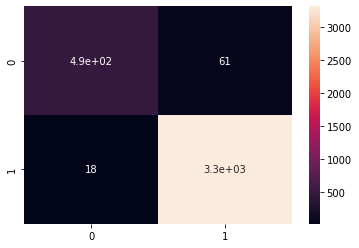

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

In [20]:
model.save('blink_or_not_ver2.h5')